# TP Large Scale Kernel Methods

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file
import warnings
warnings.filterwarnings("ignore")

## Chargement et partitionnement des données

In [2]:
###############################################################################
# Requires file ijcnn1.dat.gz to be present in the directory

dataset_path = 'ijcnn1.dat'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n1, p = X_train.shape
n2 = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n1)
print("Nombre d'exemples de test:", n2)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [75]:
from sklearn.svm import SVC, LinearSVC
from time import time
from sklearn.metrics import accuracy_score

# For SVC with rbf
print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
clf = SVC(kernel='rbf')
clf.fit(X_train,y_train)
print("Fitting SVC rbf done in %0.3fs" % (time() - t0))
print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
y_pred_kernel_svc = clf.predict(X_test)
print("Predicting with SVC rbf done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0
print("Running time SVC rbf done in %0.3fs" % timing_kernel)
accuracy_kernel = accuracy_score(y_test, y_pred_kernel_svc)
print("Classification accuracy by SVC rbf: %0.3f" % accuracy_kernel)
print("-----------------" % accuracy_kernel)

# For LinearSVC
print("Fitting SVC linear  on %d samples..." % X_train.shape[0])
t0 = time()
clf = LinearSVC()
clf.fit(X_train,y_train)
print("Fitting SVC linear done in %0.3fs" % (time() - t0))
print("Predicting with SVC linear on %d samples..." % X_test.shape[0])
t1 = time()
y_pred_linear_svc = clf.predict(X_test)
print("Predicting with SVC linear done in %0.3fs" % (time() - t1))
timing_linear = time() - t0
print("Running time SVC linear done in %0.3fs" % timing_linear)
accuracy_linear = accuracy_score(y_test, y_pred_linear_svc)
print("Classification accuracy by SVC linear: %0.3f" % accuracy_linear)

Fitting SVC rbf on 20000 samples...
Fitting SVC rbf done in 2.964s
Predicting with SVC rbf on 40000 samples...
Predicting with SVC rbf done in 3.416s
Running time SVC rbf done in 6.381s
Classification accuracy by SVC rbf: 0.980
-----------------
Fitting SVC linear  on 20000 samples...
Fitting SVC linear done in 1.922s
Predicting with SVC linear on 40000 samples...
Predicting with SVC linear done in 0.005s
Running time SVC linear done in 1.927s
Classification accuracy by SVC linear: 0.917


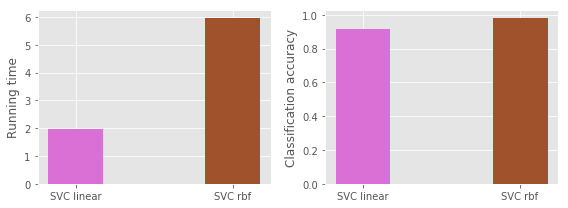

In [28]:
fig = plt.figure(figsize=(8, 3)) 
plt.subplot(121)
name = ['SVC rbf', 'SVC linear']
plt.bar(name,[timing_kernel, timing_linear], width=0.35, color=['sienna', 'orchid'] )
plt.ylabel('Running time')
plt.subplot(122)
plt.bar(['SVC rbf', 'SVC linear'],[accuracy_kernel, accuracy_linear], width=0.35, color=['sienna', 'orchid'])
plt.ylabel('Classification accuracy')
fig.tight_layout() 
plt.show()

#### Comme le montre au dessus, l'apprentissage avec un SVM linéaire est beacoup rapide que celui avec un SVM non-linéaire. Par contre, la classification de SVM non-linéaire est plus précise que SVM linéaire.

## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [5]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd
p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)


In [6]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd

def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        U, s, V = svds(gram_mat)
        S = np.diag(s[:k])
        gram_mat_k = np.dot(U[:,:k], np.dot(S, U[:,:k].T))
        
    else:
        U, s, V = svd(gram_mat)
        S = np.diag(s[:k])
        gram_mat_k = np.dot(U[:,:k], np.dot(S, U[:,:k].T))

    return gram_mat_k


## Question 3

On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [73]:
p = 200
r_noise = 100
r_signal = 20
intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

for k, rank in enumerate(ranks):
    # print(k, rank)
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0

    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    # Compute relative error with Frobenius norm
    rel_error[k] = np.linalg.norm(gram_mat_k - gram_signal)/np.linalg.norm(gram_signal)

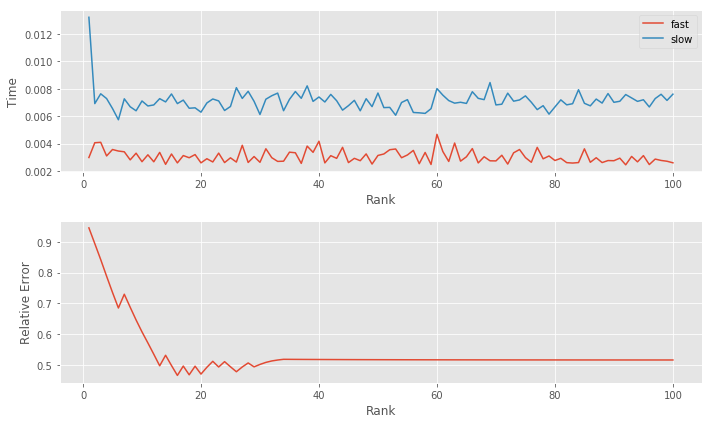

In [74]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax2.plot(ranks, rel_error, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
plt.tight_layout()
plt.show()

#### Par la comparaison du temps de calcul, la décomposition SVDS est comfirmé de plus rapide que cela de SVD. On voit pas le lien significatif entre the temps de calcul et le nombre de rank $k$. 

#### D'ailleurs, il est observé que quand le rank $k$ est petit,  plus le $k$ est grand, plus l'écart relatif en norme de Frobenius est petit. Au dessus de certain rank$k$, l'écart relatif devient consistant.

## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [9]:
def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    
    # TODO
    W = np.sqrt(2*gamma)*np.random.normal(size=(n_features,c))
    b = 2*np.pi*np.random.rand(c)
    X_new_train = np.sqrt(2/c)*np.cos((X_train.dot(W) + b[np.newaxis,:]))
    X_new_test = np.sqrt(2/c)*np.cos((X_test.dot(W) + b[np.newaxis,:]))
    
    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

In [94]:
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t1 = time()
accuracy_rkf = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t1))
timing_rkf = time() - t0
print("classification accuracy: %0.3f" % accuracy_rkf)

Fitting SVC linear on 20000 samples...
done in 1.151s
Predicting with SVC linear on 40000 samples...
done in 0.021s
classification accuracy: 0.966


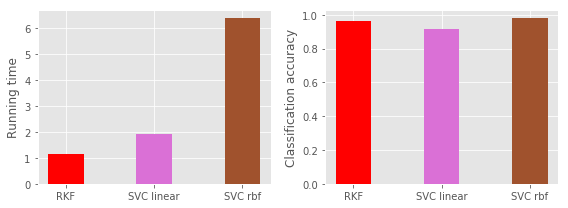

In [93]:
fig = plt.figure(figsize=(8, 3))
plt.subplot(121)
name = ['SVC rbf', 'SVC linear', 'RKF']
plt.bar(name, [timing_kernel, timing_linear, timing_rkf],
        width=0.4, color=['sienna', 'orchid', 'red'])
plt.ylabel('Running time')
plt.subplot(122)
plt.bar(['SVC rbf', 'SVC linear', 'RKF'], [accuracy_kernel,
                                                      accuracy_linear, accuracy_rkf], width=0.4, color=['sienna', 'orchid', 'red'])
plt.ylabel('Classification accuracy')
fig.tight_layout()
plt.show()

#### En utilsant Random Kernel Features, la précision de SVM linéaire est améliorée, même cela est toujours inférieur que la précision par SVM non linéaire. Cependant, le côut de calcul de RKF est intéssant, soit moitié du coût par rapport à SVM linéaire seulement.

## Question 6

On implémente la méthode de Nystrom.

In [11]:
from sklearn.metrics.pairwise import rbf_kernel

def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)
    X_train_idx = X_train[idx, :]
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)
    V, s, _ = svd(W)
    S = np.diag(s[:k])
    W_k = np.dot(V[:,:k], np.dot(S, V[:,:k].T))
    M_k = np.dot(V[:,:k], (np.linalg.inv(np.sqrt(S))))
    C_train = rbf_kernel(X_train, X_train_idx, gamma=gamma)
    C_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)
    X_new_train = np.dot(C_train,M_k)
    X_new_test = np.dot(C_test,M_k)

    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

In [96]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t1= time()
accuracy_nystrom = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t1))
timing_nystrom = time() - t0
print("classification accuracy: %0.3f" % accuracy_nystrom)


Fitting SVC linear on 20000 samples...
done in 0.929s
Predicting with SVC linear on 40000 samples...
done in 0.034s
classification accuracy: 0.976


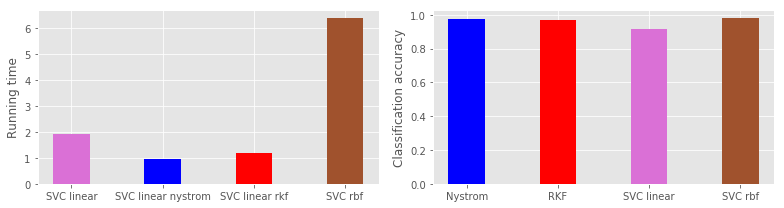

In [97]:
fig = plt.figure(figsize=(11, 3))
plt.subplot(121)
name = ['SVC rbf', 'SVC linear', 'SVC linear rkf', 'SVC linear nystrom']
plt.bar(name, [timing_kernel, timing_linear, timing_rkf, timing_nystrom], width=0.4, color=['sienna', 'orchid', 'red', 'blue'])
plt.ylabel('Running time')
plt.subplot(122)
plt.bar(['SVC rbf', 'SVC linear', 'RKF', 'Nystrom'], [accuracy_kernel,
                                                                            accuracy_linear, accuracy_rkf, accuracy_nystrom], width=0.4, color=['sienna', 'orchid', 'red', 'blue'])
plt.ylabel('Classification accuracy')
fig.tight_layout()
plt.show()

#### Grâce à ’approximation de Nyström, la prédiction de SVM linéaire est presque égale que cela de SVM non linéaire. De plus, le coût de calcul par l'approximation de Nyström, est beaucoup réduit, il est le petit parmis ces quatre approches.

## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [14]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)

n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features


print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    print(i, c)
    # TODO: compute time and prediction scores for RKF and Nystrom with respect to c
    # put results in timing_rkf, timing_nystrom, accuracy_rkf, accuracy_nystrom
    Z_train, Z_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    score_rkf= clf.score(Z_test, y_test)
    t_rkf = time() - t0
    timing_rkf[i]= t_rkf
    accuracy_rkf[i] = score_rkf
    
    
    
    Z_train, Z_test = nystrom(X_train, X_test, gamma, c=c, k=300, seed=44)
    t0 = time()
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    score_nystrom = clf.score(Z_test, y_test)
    t_nystrom = time() - t0
    timing_nystrom[i]= t_nystrom
    accuracy_nystrom[i] = score_nystrom


Training SVMs for various values of c...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


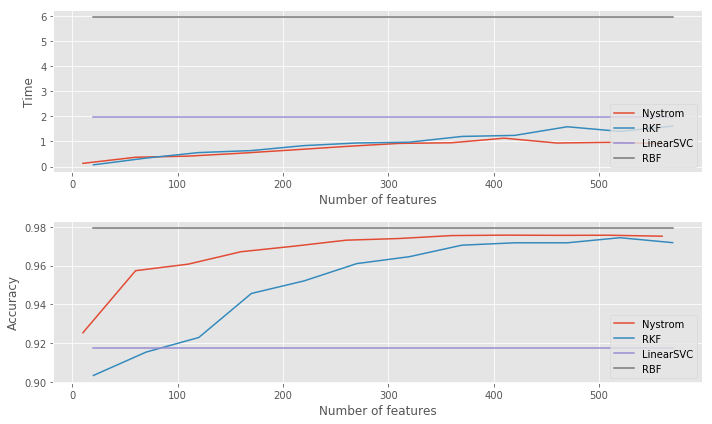

In [15]:
###############################################################################
# Display bis

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### Selon l'analyse au-dessus, le SVM non linéaire (RBF) est toujours le plus coûteux et le plus précise. le SVM linéaire est moins coûteux mais il est pas performant. Pour le RKF et Nystrom, ces coûts de calcal augmentent avec le nombre de feature, ils sont presque au même nivau, Nystrom a petit avantage de temps quand le numbre de feature est grand. En gros, les performances de RKF et Nystrom sont au milium de RBF et SVM linéaire. Mais avec l'augmentation de numbre de feature, les précisions de RKF et Nystrom montrent vers le RBF, notamment quand le numbre de feature est grand, ells sont bien proches de RBF. D'ailleurs, le Nystrom est toujours plus précise qur RKF.